In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from statistics import median

In [3]:
df0 = pd.read_csv("train.csv")
df1 = pd.read_csv("test.csv")

In [4]:
df0["Set"] = [0]*len(df0)
df1["Set"] = [1]*len(df1)

In [5]:
df = pd.merge(df0, df1, how="outer")

In [6]:
## 범주형 Dummy 생성
df = pd.get_dummies(df, columns=["Sex"]).drop(["Sex_male"], axis=1)
df = df.join(pd.get_dummies(df[["Embarked"]], columns=["Embarked"]))

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Set', 'Sex_female',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [8]:
## 일관된 형식을 위해 Name2 생성
df["Name2"] = df["Name"].replace({
    'Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")':
    'Duff Gordon, Mrs. Morgan',
    'Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")':
    'Duff Gordon, Mr. Morgan',
    'Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")':
    'Mayne, Mrs. Villiers',
    'Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall")':
    'Phillips, Mrs. Kate Louise Phillips Marshall',
    'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)':
    'Rothes, Countess. Lucy Noel Martha Dyer-Edwards',
    'Yrois, Miss. Henriette ("Mrs Harbeck")':
    'Yrois, Mrs. Harbeck'})

In [9]:
## Title
df["Title"] = df["Name2"].apply(lambda x: x.split(",")[1].strip().split(".")[0].strip())
df["Title"] = df["Title"].replace({"Capt": "Mr", "Don": "Mr", "Dona": "Ms", "Mlle": "Ms", "Mme": "Ms"})

In [10]:
## Last Name
df["LName"] = df["Name2"].apply(lambda x: x.split(",")[0].strip())
df["LName"] = df["LName"].apply(lambda x: x.title().translate(str.maketrans({" ": None, "-": None, "'": None, '"': None})))

In [11]:
## First Name
df["FName"] = df["Name2"].apply(lambda x: x.split(".")[1].strip().replace("/", " ").split(" ")[0].strip())
df["FName"] = df["FName"].apply(lambda x: x.translate(str.maketrans({"(": None, ")": None, "'": None, '"': None})))

In [12]:
df[["Name2", "Title", "LName", "FName"]].head()

,Name2,Title,LName,FName
0,"Braund, Mr. Owen Harris",Mr,Braund,Owen
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,Cumings,John
2,"Heikkinen, Miss. Laina",Miss,Heikkinen,Laina
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,Futrelle,Jacques
4,"Allen, Mr. William Henry",Mr,Allen,William


In [13]:
## 일관된 형식을 위해 Ticket2 생성
df["Ticket2"] = df["Ticket"].apply(lambda x: x.upper().translate(str.maketrans({"/": None, ".": None})).strip())
df["Ticket2"] = df["Ticket2"].apply(lambda x: "LINE/" if "LINE" in x else "".join(x.split(" ")[:-1]) + "/" + x.split(" ")[-1])

In [14]:
## Spouse
sp = {k: v["PassengerId"].tolist()
      for k, v in df[(df["SibSp"] > 0)
                     & (df["Title"].apply(lambda x: x in ["Mr", "Mrs"]))
                     & (df["Name2"].apply(lambda x: " Jr" not in x))].groupby(["LName", "FName", "Ticket2"])
      if len(v["PassengerId"]) > 1}

In [15]:
del sp[('Goodwin', 'Charles', 'CA/2144')]

In [16]:
## [Mr, Mrs] 순서로 정렬
sp = {(k if df[df["PassengerId"]==v[0]]["Sex_female"].values[0]==0 else k):
      (v if df[df["PassengerId"]==v[0]]["Sex_female"].values[0]==0 else list(reversed(v)))
      for k, v in sp.items()}

In [17]:
sp = {k: [(v[0], df[df["PassengerId"]==v[0]]["Age"].values[0]),
          (v[1], df[df["PassengerId"]==v[1]]["Age"].values[0])]
      for k, v in sp.items()}

In [18]:
list(sp.items())[0]

(('Abelson', 'Samuel', 'PPP/3381'), [(309, 30.0), (875, 28.0)])

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  3.,  7., 37., 17., 12.,  3.,  1.]),
 array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,
         25]),
 <a list of 13 Patch objects>)

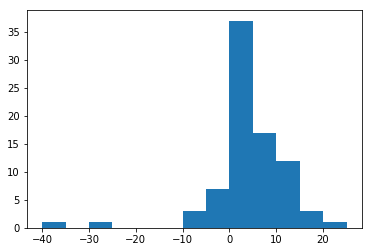

In [19]:
## 배우자 나이 차이
diff = [v[0][1] - v[1][1] for v in sp.values()]
plt.hist(diff, bins=range(-40, 30, 5))

In [20]:
"median: {}".format(round(median([v for v in diff if np.isnan(v)==False]), 3))

'median: 3.5'

In [21]:
df["Age2"] = df["Age"].copy()

for v in sp.values():
    if (np.isnan(v[0][1])==True) & (np.isnan(v[1][1])==False):
        df.loc[df["PassengerId"]==v[0][0], "Age2"] = v[1][1] + 3.5
    elif (np.isnan(v[0][1])==False) & (np.isnan(v[1][1])==True):
        df.loc[df["PassengerId"]==v[1][0], "Age2"] = v[0][1] - 3.5